In [1]:
from datasets import load_dataset, load_from_disk, DatasetDict, Dataset
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import numpy as np
# import torch.nn.functional as F
from torch.utils.data import DataLoader
from preprocessing import fen_to_piece_maps
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE == torch.device("cpu"):
    print("Using CPU, not recommended")

In [3]:
def collate_fn(batch):
    batch_fens = [example['fen'] for example in batch]
    labels = torch.tensor(
        [example['target'] for example in batch],
        dtype=torch.float32
    )

    winning_labels = []
    inputs = []

    for example in batch:
        fen = example['fen']
        target = example['target']
        
        # Parse side to move
        stm = fen.split()[1]  # 'w' or 'b'

        # Compute winning label
        if (stm == 'w' and target > 0) or (stm == 'b' and target < 0):
            winning = 1
        else:
            winning = 0

        winning_labels.append(winning)

        # Process input
        inputs.append(torch.tensor(fen_to_piece_maps(fen), dtype=torch.float32))

    inputs = torch.stack(inputs)
    winning_labels = torch.tensor(winning_labels, dtype=torch.float32)  # Make sure it's float32 for BCEWithLogitsLoss etc.

    return inputs, labels, winning_labels

In [4]:
dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_part1"))

# Split the dataset into train, validation, and test sets
train_size = int(0.98 * len(dataset))
val_size = int(0.01 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
test_dataset = dataset.select(range(train_size + val_size, len(dataset)))
num_training_examples = len(train_dataset)

train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

# Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Save the DatasetDict to disk
dataset_dict.save_to_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split"))

Saving the dataset (0/8 shards):   0%|          | 0/58800000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/600000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/600000 [00:00<?, ? examples/s]

In [5]:
train_dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split/train"))
val_dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split/validation"))
test_dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split/test"))

num_training_examples = len(train_dataset)

train_dataset = train_dataset.to_iterable_dataset(num_shards=32)
val_dataset = val_dataset.to_iterable_dataset()
test_dataset = test_dataset.to_iterable_dataset()

train_dataset = train_dataset.shuffle(buffer_size=10000)
val_dataset = val_dataset.shuffle(buffer_size=10000)
test_dataset = test_dataset.shuffle(buffer_size=10000)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=256, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=256, collate_fn=collate_fn)

In [15]:
import torch
import torch.nn as nn

class FFN(nn.Module):
    def __init__(self, input_size, hidden_size=256, dropout_prob=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return x

class ChessEvalMLP(nn.Module):
    def __init__(self, input_planes=17, hidden_size=512, dropout_prob=0.1):
        super().__init__()
        input_size = input_planes * 8 * 8  # because of piece maps (channels * 8 * 8)

        self.backbone = FFN(input_size, hidden_size=hidden_size, dropout_prob=dropout_prob)

        # Two heads
        self.eval_head = nn.Linear(hidden_size // 2, 1)  # For regression
        self.win_head = nn.Linear(hidden_size // 2, 1)   # For binary classification

    def forward(self, x):
        x = torch.flatten(x, 1)  # (batch_size, channels*8*8)
        features = self.backbone(x)
        eval_output = self.eval_head(features)     # Regression output (centipawns)
        win_output = self.win_head(features)       # Classification output (winning/not)

        return eval_output, win_output

In [16]:
input_tensor = torch.randn(32, 17, 8, 8)  # A batch of 32 chessboard positions

model = ChessEvalMLP()
output = model(input_tensor)

print(output[0].shape, output[1].shape)

torch.Size([32, 1]) torch.Size([32, 1])


In [17]:
NUM_EPOCHS = 1
total_iters = NUM_EPOCHS * ((num_training_examples // 256) + 1)

model = ChessEvalMLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=total_iters, eta_min=1e-4)
eval_criterion = nn.MSELoss()
win_criterion = nn.BCEWithLogitsLoss()

In [18]:
best_val_loss = float('inf')
best_val_mae = float('inf')
num_iterations = 0
patience_counter = 0

PATIENCE = 25000
MIN_IMPROVEMENT = 5e-4
VAL_ITERS = 5000
LOG_ITERS = 1000

early_stop = False

# for tracking performance
steps = []
train_losses, train_maes, train_win_accs = [], [], []
val_losses, val_maes, val_win_accs = [], [], []

for epoch in range(1, NUM_EPOCHS + 1):
    if early_stop:
        break

    model.train()
    total_loss = 0.0
    total_mae = 0.0
    total_win_correct = 0
    total_samples = 0

    for inputs, labels, winning_labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        inputs, labels, winning_labels = inputs.to(DEVICE), labels.to(DEVICE), winning_labels.to(DEVICE)

        optimizer.zero_grad()
        eval_pred, win_pred = model(inputs)

        loss_eval = eval_criterion(eval_pred.squeeze(), labels)
        loss_win = win_criterion(win_pred.squeeze(), winning_labels)

        loss = loss_eval + loss_win

        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_loss = loss.item()
        batch_mae = torch.mean(torch.abs(eval_pred.squeeze() - labels)).item()

        # Calculate batch binary accuracy
        win_pred_labels = (torch.sigmoid(win_pred.squeeze()) > 0.5).float()
        batch_win_acc = (win_pred_labels == winning_labels).float().mean().item()

        total_loss += batch_loss * inputs.size(0)
        total_mae += batch_mae * inputs.size(0)
        total_win_correct += (win_pred_labels == winning_labels).sum().item()
        total_samples += inputs.size(0)
        num_iterations += 1

        if num_iterations % LOG_ITERS == 0:
            avg_train_loss = total_loss / total_samples
            avg_train_mae = total_mae / total_samples
            avg_train_win_acc = total_win_correct / total_samples

            print(f"Step {num_iterations} — train_loss: {avg_train_loss:.4f}, train_mae: {avg_train_mae:.4f}, train_win_acc: {avg_train_win_acc:.4f}")

    # Validation every VAL_ITERS iterations
        if num_iterations % VAL_ITERS == 0:
            model.eval()
            val_loss_sum = 0.0
            val_mae_sum = 0.0
            val_win_correct = 0
            val_total_samples = 0

            with torch.no_grad():
                for val_inputs, val_labels, val_winning_labels in val_loader:
                    val_inputs, val_labels, val_winning_labels = val_inputs.to(DEVICE), val_labels.to(DEVICE), val_winning_labels.to(DEVICE)

                    val_pred, val_win_pred = model(val_inputs)

                    val_loss = eval_criterion(val_pred.squeeze(), val_labels)
                    val_mae = torch.mean(torch.abs(val_pred.squeeze() - val_labels))

                    val_loss_sum += val_loss.item() * val_inputs.size(0)
                    val_mae_sum += val_mae.item() * val_inputs.size(0)

                    val_win_preds = (torch.sigmoid(val_win_pred.squeeze()) > 0.5).float()
                    val_win_correct += (val_win_preds == val_winning_labels).sum().item()

                    val_total_samples += val_inputs.size(0)

            avg_val_loss = val_loss_sum / val_total_samples
            avg_val_mae = val_mae_sum / val_total_samples
            avg_val_win_acc = val_win_correct / val_total_samples

            avg_train_loss = total_loss / total_samples
            avg_train_mae = total_mae / total_samples
            avg_train_win_acc = total_win_correct / total_samples

            print(f"\n[Validation] Step {num_iterations} — train_loss: {avg_train_loss:.4f}, train_mae: {avg_train_mae:.4f}, train_win_acc: {avg_train_win_acc:.4f}, val_loss: {avg_val_loss:.4f}, val_mae: {avg_val_mae:.4f}, val_win_acc: {avg_val_win_acc:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

            steps.append(num_iterations)
            train_losses.append(avg_train_loss)
            train_maes.append(avg_train_mae)
            train_win_accs.append(avg_train_win_acc)

            val_losses.append(avg_val_loss)
            val_maes.append(avg_val_mae)
            val_win_accs.append(avg_val_win_acc)

            # Checkpoint best
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), "best_chess_mlp.pth")
                print(f"Saved new best model after {num_iterations} iters")
            
            # Early stopping on validation MAE
            if avg_val_mae + MIN_IMPROVEMENT < best_val_mae:
                best_val_mae = avg_val_mae
                patience_counter = 0
                print(f"--------Validation MAE improved to {best_val_mae:.6f}--------")
            else:
                patience_counter += VAL_ITERS
                print(f"--------No significant MAE improvement for {patience_counter} iterations--------")

            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at {num_iterations} iterations (no significant MAE improvement)")
                early_stop = True
                break

            model.train()


Epoch 1: 1006it [00:28, 35.70it/s]

Step 1000 — train_loss: 0.6486, train_mae: 0.2300, train_win_acc: 0.7208


Epoch 1: 2006it [00:56, 35.18it/s]

Step 2000 — train_loss: 0.6163, train_mae: 0.2203, train_win_acc: 0.7391


Epoch 1: 3006it [01:24, 35.72it/s]

Step 3000 — train_loss: 0.6070, train_mae: 0.2161, train_win_acc: 0.7443


Epoch 1: 4006it [01:52, 35.18it/s]

Step 4000 — train_loss: 0.5996, train_mae: 0.2130, train_win_acc: 0.7481


Epoch 1: 4998it [02:19, 34.77it/s]

Step 5000 — train_loss: 0.5935, train_mae: 0.2110, train_win_acc: 0.7515


Epoch 1: 5004it [03:23,  3.73s/it]


[Validation] Step 5000 — train_loss: 0.5935, train_mae: 0.2110, train_win_acc: 0.7515, val_loss: 0.1121, val_mae: 0.2259, val_win_acc: 0.7071, LR: 0.000999
Saved new best model after 5000 iters
--------Validation MAE improved to 0.225945--------


Epoch 1: 6004it [03:50, 36.98it/s]

Step 6000 — train_loss: 0.5902, train_mae: 0.2091, train_win_acc: 0.7534


Epoch 1: 7004it [04:18, 36.78it/s]

Step 7000 — train_loss: 0.5882, train_mae: 0.2082, train_win_acc: 0.7548


Epoch 1: 8004it [04:45, 37.11it/s]

Step 8000 — train_loss: 0.5850, train_mae: 0.2076, train_win_acc: 0.7567


Epoch 1: 9004it [05:12, 36.24it/s]

Step 9000 — train_loss: 0.5833, train_mae: 0.2071, train_win_acc: 0.7576


Epoch 1: 9996it [05:39, 36.64it/s]

Step 10000 — train_loss: 0.5810, train_mae: 0.2060, train_win_acc: 0.7586


Epoch 1: 10004it [06:40,  3.24s/it]


[Validation] Step 10000 — train_loss: 0.5810, train_mae: 0.2060, train_win_acc: 0.7586, val_loss: 0.1022, val_mae: 0.2113, val_win_acc: 0.7241, LR: 0.000996
Saved new best model after 10000 iters
--------Validation MAE improved to 0.211325--------


Epoch 1: 11004it [07:08, 36.59it/s]

Step 11000 — train_loss: 0.5784, train_mae: 0.2059, train_win_acc: 0.7604


Epoch 1: 12004it [07:35, 36.14it/s]

Step 12000 — train_loss: 0.5769, train_mae: 0.2051, train_win_acc: 0.7611


Epoch 1: 13004it [08:04, 32.70it/s]

Step 13000 — train_loss: 0.5752, train_mae: 0.2048, train_win_acc: 0.7623


Epoch 1: 14004it [08:32, 36.59it/s]

Step 14000 — train_loss: 0.5733, train_mae: 0.2039, train_win_acc: 0.7631


Epoch 1: 14996it [08:59, 36.82it/s]

Step 15000 — train_loss: 0.5728, train_mae: 0.2032, train_win_acc: 0.7634


Epoch 1: 15004it [10:00,  3.21s/it]


[Validation] Step 15000 — train_loss: 0.5728, train_mae: 0.2032, train_win_acc: 0.7634, val_loss: 0.0991, val_mae: 0.2070, val_win_acc: 0.7308, LR: 0.000991
Saved new best model after 15000 iters
--------Validation MAE improved to 0.206955--------


Epoch 1: 16004it [10:28, 36.02it/s]

Step 16000 — train_loss: 0.5719, train_mae: 0.2032, train_win_acc: 0.7640


Epoch 1: 17004it [10:56, 35.49it/s]

Step 17000 — train_loss: 0.5711, train_mae: 0.2027, train_win_acc: 0.7642


Epoch 1: 18004it [11:24, 35.99it/s]

Step 18000 — train_loss: 0.5706, train_mae: 0.2022, train_win_acc: 0.7643


Epoch 1: 19004it [11:52, 37.01it/s]

Step 19000 — train_loss: 0.5701, train_mae: 0.2016, train_win_acc: 0.7645


Epoch 1: 19996it [12:19, 36.54it/s]

Step 20000 — train_loss: 0.5689, train_mae: 0.2016, train_win_acc: 0.7653


Epoch 1: 20004it [13:20,  3.24s/it]


[Validation] Step 20000 — train_loss: 0.5689, train_mae: 0.2016, train_win_acc: 0.7653, val_loss: 0.0980, val_mae: 0.2072, val_win_acc: 0.7357, LR: 0.000983
Saved new best model after 20000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 21004it [13:49, 33.06it/s]

Step 21000 — train_loss: 0.5675, train_mae: 0.2010, train_win_acc: 0.7660


Epoch 1: 22004it [14:17, 36.80it/s]

Step 22000 — train_loss: 0.5662, train_mae: 0.2001, train_win_acc: 0.7665


Epoch 1: 23004it [14:44, 36.68it/s]

Step 23000 — train_loss: 0.5641, train_mae: 0.1988, train_win_acc: 0.7674


Epoch 1: 24004it [15:12, 36.73it/s]

Step 24000 — train_loss: 0.5634, train_mae: 0.1982, train_win_acc: 0.7680


Epoch 1: 24996it [15:39, 36.75it/s]

Step 25000 — train_loss: 0.5624, train_mae: 0.1973, train_win_acc: 0.7683


Epoch 1: 25004it [16:40,  3.21s/it]


[Validation] Step 25000 — train_loss: 0.5624, train_mae: 0.1973, train_win_acc: 0.7683, val_loss: 0.0980, val_mae: 0.2068, val_win_acc: 0.7376, LR: 0.000974
Saved new best model after 25000 iters
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 26004it [17:07, 36.25it/s]

Step 26000 — train_loss: 0.5610, train_mae: 0.1964, train_win_acc: 0.7688


Epoch 1: 27004it [17:34, 37.09it/s]

Step 27000 — train_loss: 0.5601, train_mae: 0.1958, train_win_acc: 0.7692


Epoch 1: 28004it [18:02, 36.74it/s]

Step 28000 — train_loss: 0.5594, train_mae: 0.1952, train_win_acc: 0.7694


Epoch 1: 29004it [18:29, 37.05it/s]

Step 29000 — train_loss: 0.5570, train_mae: 0.1948, train_win_acc: 0.7707


Epoch 1: 29996it [18:57, 32.60it/s]

Step 30000 — train_loss: 0.5560, train_mae: 0.1946, train_win_acc: 0.7712


Epoch 1: 30004it [19:58,  3.26s/it]


[Validation] Step 30000 — train_loss: 0.5560, train_mae: 0.1946, train_win_acc: 0.7712, val_loss: 0.0954, val_mae: 0.2036, val_win_acc: 0.7422, LR: 0.000963
Saved new best model after 30000 iters
--------Validation MAE improved to 0.203555--------


Epoch 1: 31004it [20:26, 36.86it/s]

Step 31000 — train_loss: 0.5555, train_mae: 0.1943, train_win_acc: 0.7714


Epoch 1: 32004it [20:53, 36.43it/s]

Step 32000 — train_loss: 0.5551, train_mae: 0.1939, train_win_acc: 0.7716


Epoch 1: 33004it [21:21, 37.19it/s]

Step 33000 — train_loss: 0.5524, train_mae: 0.1936, train_win_acc: 0.7731


Epoch 1: 34004it [21:48, 36.64it/s]

Step 34000 — train_loss: 0.5514, train_mae: 0.1934, train_win_acc: 0.7736


Epoch 1: 34996it [22:15, 36.02it/s]

Step 35000 — train_loss: 0.5509, train_mae: 0.1932, train_win_acc: 0.7739


Epoch 1: 35004it [23:16,  3.22s/it]


[Validation] Step 35000 — train_loss: 0.5509, train_mae: 0.1932, train_win_acc: 0.7739, val_loss: 0.0932, val_mae: 0.2032, val_win_acc: 0.7416, LR: 0.000949
Saved new best model after 35000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 36004it [23:44, 35.62it/s]

Step 36000 — train_loss: 0.5506, train_mae: 0.1929, train_win_acc: 0.7740


Epoch 1: 37004it [24:11, 35.88it/s]

Step 37000 — train_loss: 0.5505, train_mae: 0.1930, train_win_acc: 0.7740


Epoch 1: 38004it [24:39, 32.55it/s]

Step 38000 — train_loss: 0.5505, train_mae: 0.1929, train_win_acc: 0.7740


Epoch 1: 39004it [25:08, 36.73it/s]

Step 39000 — train_loss: 0.5500, train_mae: 0.1929, train_win_acc: 0.7743


Epoch 1: 39996it [25:36, 36.95it/s]

Step 40000 — train_loss: 0.5499, train_mae: 0.1927, train_win_acc: 0.7743


Epoch 1: 40004it [26:37,  3.21s/it]


[Validation] Step 40000 — train_loss: 0.5499, train_mae: 0.1927, train_win_acc: 0.7743, val_loss: 0.0929, val_mae: 0.1993, val_win_acc: 0.7449, LR: 0.000934
Saved new best model after 40000 iters
--------Validation MAE improved to 0.199329--------


Epoch 1: 41004it [27:04, 36.98it/s]

Step 41000 — train_loss: 0.5497, train_mae: 0.1926, train_win_acc: 0.7745


Epoch 1: 42004it [27:31, 37.05it/s]

Step 42000 — train_loss: 0.5492, train_mae: 0.1923, train_win_acc: 0.7746


Epoch 1: 43004it [27:58, 36.96it/s]

Step 43000 — train_loss: 0.5489, train_mae: 0.1922, train_win_acc: 0.7747


Epoch 1: 44004it [28:27, 36.84it/s]

Step 44000 — train_loss: 0.5485, train_mae: 0.1919, train_win_acc: 0.7748


Epoch 1: 44996it [28:54, 37.08it/s]

Step 45000 — train_loss: 0.5481, train_mae: 0.1915, train_win_acc: 0.7750


Epoch 1: 45004it [29:55,  3.21s/it]


[Validation] Step 45000 — train_loss: 0.5481, train_mae: 0.1915, train_win_acc: 0.7750, val_loss: 0.0913, val_mae: 0.1963, val_win_acc: 0.7507, LR: 0.000917
Saved new best model after 45000 iters
--------Validation MAE improved to 0.196270--------


Epoch 1: 46004it [30:22, 37.13it/s]

Step 46000 — train_loss: 0.5475, train_mae: 0.1913, train_win_acc: 0.7752


Epoch 1: 47004it [30:50, 36.81it/s]

Step 47000 — train_loss: 0.5470, train_mae: 0.1908, train_win_acc: 0.7755


Epoch 1: 48004it [31:17, 36.88it/s]

Step 48000 — train_loss: 0.5457, train_mae: 0.1908, train_win_acc: 0.7763


Epoch 1: 49004it [31:45, 36.63it/s]

Step 49000 — train_loss: 0.5455, train_mae: 0.1908, train_win_acc: 0.7764


Epoch 1: 49996it [32:13, 36.68it/s]

Step 50000 — train_loss: 0.5452, train_mae: 0.1905, train_win_acc: 0.7764


Epoch 1: 50004it [33:14,  3.23s/it]


[Validation] Step 50000 — train_loss: 0.5452, train_mae: 0.1905, train_win_acc: 0.7764, val_loss: 0.0895, val_mae: 0.1937, val_win_acc: 0.7508, LR: 0.000899
Saved new best model after 50000 iters
--------Validation MAE improved to 0.193729--------


Epoch 1: 51004it [33:42, 35.79it/s]

Step 51000 — train_loss: 0.5453, train_mae: 0.1903, train_win_acc: 0.7763


Epoch 1: 52004it [34:09, 35.52it/s]

Step 52000 — train_loss: 0.5451, train_mae: 0.1904, train_win_acc: 0.7764


Epoch 1: 53004it [34:37, 37.08it/s]

Step 53000 — train_loss: 0.5447, train_mae: 0.1902, train_win_acc: 0.7766


Epoch 1: 54004it [35:06, 32.87it/s]

Step 54000 — train_loss: 0.5448, train_mae: 0.1903, train_win_acc: 0.7768


Epoch 1: 54996it [35:34, 35.35it/s]

Step 55000 — train_loss: 0.5447, train_mae: 0.1902, train_win_acc: 0.7767


Epoch 1: 55004it [36:35,  3.21s/it]


[Validation] Step 55000 — train_loss: 0.5447, train_mae: 0.1902, train_win_acc: 0.7767, val_loss: 0.0879, val_mae: 0.1923, val_win_acc: 0.7595, LR: 0.000879
Saved new best model after 55000 iters
--------Validation MAE improved to 0.192350--------


Epoch 1: 56004it [37:03, 36.88it/s]

Step 56000 — train_loss: 0.5445, train_mae: 0.1901, train_win_acc: 0.7768


Epoch 1: 57004it [37:30, 35.77it/s]

Step 57000 — train_loss: 0.5443, train_mae: 0.1901, train_win_acc: 0.7769


Epoch 1: 58004it [37:58, 36.58it/s]

Step 58000 — train_loss: 0.5442, train_mae: 0.1900, train_win_acc: 0.7769


Epoch 1: 59004it [38:25, 36.64it/s]

Step 59000 — train_loss: 0.5442, train_mae: 0.1900, train_win_acc: 0.7770


Epoch 1: 59996it [38:52, 36.33it/s]

Step 60000 — train_loss: 0.5439, train_mae: 0.1899, train_win_acc: 0.7771


Epoch 1: 60004it [39:56,  3.39s/it]


[Validation] Step 60000 — train_loss: 0.5439, train_mae: 0.1899, train_win_acc: 0.7771, val_loss: 0.0863, val_mae: 0.1917, val_win_acc: 0.7603, LR: 0.000857
Saved new best model after 60000 iters
--------Validation MAE improved to 0.191726--------


Epoch 1: 61004it [40:25, 34.68it/s]

Step 61000 — train_loss: 0.5436, train_mae: 0.1898, train_win_acc: 0.7772


Epoch 1: 62004it [40:54, 36.64it/s]

Step 62000 — train_loss: 0.5433, train_mae: 0.1897, train_win_acc: 0.7774


Epoch 1: 63004it [41:22, 35.03it/s]

Step 63000 — train_loss: 0.5429, train_mae: 0.1896, train_win_acc: 0.7776


Epoch 1: 64004it [41:50, 36.35it/s]

Step 64000 — train_loss: 0.5425, train_mae: 0.1894, train_win_acc: 0.7777


Epoch 1: 64996it [42:17, 36.26it/s]

Step 65000 — train_loss: 0.5423, train_mae: 0.1894, train_win_acc: 0.7779


Epoch 1: 65004it [43:19,  3.26s/it]


[Validation] Step 65000 — train_loss: 0.5423, train_mae: 0.1894, train_win_acc: 0.7779, val_loss: 0.0864, val_mae: 0.1909, val_win_acc: 0.7603, LR: 0.000834
--------Validation MAE improved to 0.190886--------


Epoch 1: 66004it [43:47, 35.29it/s]

Step 66000 — train_loss: 0.5420, train_mae: 0.1893, train_win_acc: 0.7780


Epoch 1: 67004it [44:15, 35.87it/s]

Step 67000 — train_loss: 0.5418, train_mae: 0.1893, train_win_acc: 0.7781


Epoch 1: 68004it [44:43, 26.57it/s]

Step 68000 — train_loss: 0.5416, train_mae: 0.1892, train_win_acc: 0.7782


Epoch 1: 69004it [45:11, 36.51it/s]

Step 69000 — train_loss: 0.5414, train_mae: 0.1892, train_win_acc: 0.7783


Epoch 1: 69996it [45:38, 36.18it/s]

Step 70000 — train_loss: 0.5411, train_mae: 0.1891, train_win_acc: 0.7784


Epoch 1: 70004it [46:43,  3.39s/it]


[Validation] Step 70000 — train_loss: 0.5411, train_mae: 0.1891, train_win_acc: 0.7784, val_loss: 0.0855, val_mae: 0.1904, val_win_acc: 0.7618, LR: 0.000809
Saved new best model after 70000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 71004it [47:11, 35.87it/s]

Step 71000 — train_loss: 0.5409, train_mae: 0.1890, train_win_acc: 0.7785


Epoch 1: 72004it [47:39, 36.23it/s]

Step 72000 — train_loss: 0.5407, train_mae: 0.1890, train_win_acc: 0.7786


Epoch 1: 73004it [48:07, 35.87it/s]

Step 73000 — train_loss: 0.5405, train_mae: 0.1889, train_win_acc: 0.7787


Epoch 1: 74005it [48:36, 32.85it/s]

Step 74000 — train_loss: 0.5405, train_mae: 0.1888, train_win_acc: 0.7787


Epoch 1: 74997it [49:05, 34.83it/s]

Step 75000 — train_loss: 0.5402, train_mae: 0.1887, train_win_acc: 0.7788


Epoch 1: 75004it [50:06,  3.42s/it]


[Validation] Step 75000 — train_loss: 0.5402, train_mae: 0.1887, train_win_acc: 0.7788, val_loss: 0.0875, val_mae: 0.1914, val_win_acc: 0.7620, LR: 0.000783
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 76004it [50:34, 34.96it/s]

Step 76000 — train_loss: 0.5401, train_mae: 0.1888, train_win_acc: 0.7790


Epoch 1: 77003it [51:03, 35.19it/s]

Step 77000 — train_loss: 0.5399, train_mae: 0.1887, train_win_acc: 0.7790


Epoch 1: 78003it [51:31, 35.17it/s]

Step 78000 — train_loss: 0.5398, train_mae: 0.1886, train_win_acc: 0.7791


Epoch 1: 79007it [52:00, 35.46it/s]

Step 79000 — train_loss: 0.5396, train_mae: 0.1885, train_win_acc: 0.7792


Epoch 1: 79999it [52:30, 34.12it/s]

Step 80000 — train_loss: 0.5395, train_mae: 0.1884, train_win_acc: 0.7793


Epoch 1: 80004it [53:32,  3.92s/it]


[Validation] Step 80000 — train_loss: 0.5395, train_mae: 0.1884, train_win_acc: 0.7793, val_loss: 0.0848, val_mae: 0.1882, val_win_acc: 0.7621, LR: 0.000756
Saved new best model after 80000 iters
--------Validation MAE improved to 0.188155--------


Epoch 1: 81004it [54:00, 35.82it/s]

Step 81000 — train_loss: 0.5394, train_mae: 0.1883, train_win_acc: 0.7793


Epoch 1: 82004it [54:28, 36.39it/s]

Step 82000 — train_loss: 0.5392, train_mae: 0.1882, train_win_acc: 0.7794


Epoch 1: 83004it [54:56, 34.82it/s]

Step 83000 — train_loss: 0.5391, train_mae: 0.1882, train_win_acc: 0.7794


Epoch 1: 84004it [55:24, 35.34it/s]

Step 84000 — train_loss: 0.5389, train_mae: 0.1882, train_win_acc: 0.7796


Epoch 1: 84996it [55:52, 34.66it/s]

Step 85000 — train_loss: 0.5388, train_mae: 0.1881, train_win_acc: 0.7796


Epoch 1: 85004it [56:54,  3.27s/it]


[Validation] Step 85000 — train_loss: 0.5388, train_mae: 0.1881, train_win_acc: 0.7796, val_loss: 0.0828, val_mae: 0.1856, val_win_acc: 0.7662, LR: 0.000729
Saved new best model after 85000 iters
--------Validation MAE improved to 0.185571--------


Epoch 1: 86004it [57:22, 35.56it/s]

Step 86000 — train_loss: 0.5387, train_mae: 0.1881, train_win_acc: 0.7797


Epoch 1: 87006it [57:50, 35.98it/s]

Step 87000 — train_loss: 0.5384, train_mae: 0.1880, train_win_acc: 0.7798


Epoch 1: 88006it [58:18, 35.94it/s]

Step 88000 — train_loss: 0.5381, train_mae: 0.1879, train_win_acc: 0.7800


Epoch 1: 89006it [58:46, 35.48it/s]

Step 89000 — train_loss: 0.5375, train_mae: 0.1878, train_win_acc: 0.7802


Epoch 1: 89998it [59:14, 35.99it/s]

Step 90000 — train_loss: 0.5373, train_mae: 0.1877, train_win_acc: 0.7804


Epoch 1: 90004it [1:00:15,  3.61s/it]


[Validation] Step 90000 — train_loss: 0.5373, train_mae: 0.1877, train_win_acc: 0.7804, val_loss: 0.0831, val_mae: 0.1866, val_win_acc: 0.7669, LR: 0.000700
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 91004it [1:00:44, 35.24it/s]

Step 91000 — train_loss: 0.5370, train_mae: 0.1876, train_win_acc: 0.7805


Epoch 1: 92004it [1:01:12, 34.99it/s]

Step 92000 — train_loss: 0.5368, train_mae: 0.1876, train_win_acc: 0.7807


Epoch 1: 93004it [1:01:41, 31.66it/s]

Step 93000 — train_loss: 0.5366, train_mae: 0.1875, train_win_acc: 0.7808


Epoch 1: 94004it [1:02:10, 35.86it/s]

Step 94000 — train_loss: 0.5363, train_mae: 0.1875, train_win_acc: 0.7809


Epoch 1: 94997it [1:02:39, 30.28it/s]

Step 95000 — train_loss: 0.5360, train_mae: 0.1874, train_win_acc: 0.7811


Epoch 1: 95003it [1:03:43,  3.89s/it]


[Validation] Step 95000 — train_loss: 0.5360, train_mae: 0.1874, train_win_acc: 0.7811, val_loss: 0.0827, val_mae: 0.1859, val_win_acc: 0.7698, LR: 0.000671
Saved new best model after 95000 iters
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 96007it [1:04:11, 35.06it/s]

Step 96000 — train_loss: 0.5357, train_mae: 0.1873, train_win_acc: 0.7812


Epoch 1: 97005it [1:04:40, 35.48it/s]

Step 97000 — train_loss: 0.5354, train_mae: 0.1873, train_win_acc: 0.7814


Epoch 1: 98005it [1:05:08, 36.65it/s]

Step 98000 — train_loss: 0.5352, train_mae: 0.1873, train_win_acc: 0.7815


Epoch 1: 99007it [1:05:37, 36.15it/s]

Step 99000 — train_loss: 0.5351, train_mae: 0.1872, train_win_acc: 0.7815


Epoch 1: 99999it [1:06:05, 34.10it/s]

Step 100000 — train_loss: 0.5350, train_mae: 0.1872, train_win_acc: 0.7816


Epoch 1: 100004it [1:07:07,  3.89s/it]


[Validation] Step 100000 — train_loss: 0.5350, train_mae: 0.1872, train_win_acc: 0.7816, val_loss: 0.0811, val_mae: 0.1833, val_win_acc: 0.7738, LR: 0.000641
Saved new best model after 100000 iters
--------Validation MAE improved to 0.183324--------


Epoch 1: 101004it [1:07:35, 36.41it/s]

Step 101000 — train_loss: 0.5348, train_mae: 0.1871, train_win_acc: 0.7816


Epoch 1: 102004it [1:08:03, 35.02it/s]

Step 102000 — train_loss: 0.5347, train_mae: 0.1871, train_win_acc: 0.7817


Epoch 1: 103007it [1:08:31, 35.75it/s]

Step 103000 — train_loss: 0.5345, train_mae: 0.1870, train_win_acc: 0.7818


Epoch 1: 104007it [1:09:00, 35.78it/s]

Step 104000 — train_loss: 0.5343, train_mae: 0.1870, train_win_acc: 0.7819


Epoch 1: 104999it [1:09:28, 36.23it/s]

Step 105000 — train_loss: 0.5342, train_mae: 0.1870, train_win_acc: 0.7820


Epoch 1: 105004it [1:10:29,  3.86s/it]


[Validation] Step 105000 — train_loss: 0.5342, train_mae: 0.1870, train_win_acc: 0.7820, val_loss: 0.0814, val_mae: 0.1855, val_win_acc: 0.7686, LR: 0.000610
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 106004it [1:10:59, 32.84it/s]

Step 106000 — train_loss: 0.5341, train_mae: 0.1869, train_win_acc: 0.7821


Epoch 1: 107006it [1:11:27, 36.55it/s]

Step 107000 — train_loss: 0.5340, train_mae: 0.1869, train_win_acc: 0.7821


Epoch 1: 108006it [1:11:55, 36.69it/s]

Step 108000 — train_loss: 0.5338, train_mae: 0.1868, train_win_acc: 0.7822


Epoch 1: 109005it [1:12:23, 36.46it/s]

Step 109000 — train_loss: 0.5337, train_mae: 0.1868, train_win_acc: 0.7823


Epoch 1: 109996it [1:12:52, 36.15it/s]

Step 110000 — train_loss: 0.5335, train_mae: 0.1867, train_win_acc: 0.7823


Epoch 1: 110004it [1:13:54,  3.27s/it]


[Validation] Step 110000 — train_loss: 0.5335, train_mae: 0.1867, train_win_acc: 0.7823, val_loss: 0.0803, val_mae: 0.1802, val_win_acc: 0.7745, LR: 0.000580
Saved new best model after 110000 iters
--------Validation MAE improved to 0.180151--------


Epoch 1: 111004it [1:14:21, 36.31it/s]

Step 111000 — train_loss: 0.5333, train_mae: 0.1867, train_win_acc: 0.7824


Epoch 1: 112004it [1:14:49, 35.44it/s]

Step 112000 — train_loss: 0.5331, train_mae: 0.1866, train_win_acc: 0.7825


Epoch 1: 113007it [1:15:18, 35.16it/s]

Step 113000 — train_loss: 0.5329, train_mae: 0.1865, train_win_acc: 0.7826


Epoch 1: 114007it [1:15:47, 35.55it/s]

Step 114000 — train_loss: 0.5327, train_mae: 0.1864, train_win_acc: 0.7827


Epoch 1: 114999it [1:16:15, 36.90it/s]

Step 115000 — train_loss: 0.5326, train_mae: 0.1864, train_win_acc: 0.7828


Epoch 1: 115004it [1:17:17,  3.92s/it]


[Validation] Step 115000 — train_loss: 0.5326, train_mae: 0.1864, train_win_acc: 0.7828, val_loss: 0.0805, val_mae: 0.1829, val_win_acc: 0.7732, LR: 0.000549
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 116007it [1:17:46, 36.11it/s]

Step 116000 — train_loss: 0.5324, train_mae: 0.1863, train_win_acc: 0.7829


Epoch 1: 117007it [1:18:14, 35.99it/s]

Step 117000 — train_loss: 0.5322, train_mae: 0.1862, train_win_acc: 0.7829


Epoch 1: 118007it [1:18:42, 36.38it/s]

Step 118000 — train_loss: 0.5320, train_mae: 0.1861, train_win_acc: 0.7830


Epoch 1: 119003it [1:19:10, 34.96it/s]

Step 119000 — train_loss: 0.5317, train_mae: 0.1860, train_win_acc: 0.7831


Epoch 1: 119999it [1:19:38, 35.63it/s]

Step 120000 — train_loss: 0.5315, train_mae: 0.1859, train_win_acc: 0.7833


Epoch 1: 120004it [1:20:40,  3.84s/it]


[Validation] Step 120000 — train_loss: 0.5315, train_mae: 0.1859, train_win_acc: 0.7833, val_loss: 0.0801, val_mae: 0.1798, val_win_acc: 0.7748, LR: 0.000518
Saved new best model after 120000 iters
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 121004it [1:21:08, 34.97it/s]

Step 121000 — train_loss: 0.5312, train_mae: 0.1858, train_win_acc: 0.7834


Epoch 1: 122004it [1:21:36, 35.17it/s]

Step 122000 — train_loss: 0.5310, train_mae: 0.1857, train_win_acc: 0.7835


Epoch 1: 123007it [1:22:06, 36.05it/s]

Step 123000 — train_loss: 0.5308, train_mae: 0.1857, train_win_acc: 0.7835


Epoch 1: 124007it [1:22:34, 34.76it/s]

Step 124000 — train_loss: 0.5306, train_mae: 0.1856, train_win_acc: 0.7836


Epoch 1: 124999it [1:23:02, 35.11it/s]

Step 125000 — train_loss: 0.5305, train_mae: 0.1856, train_win_acc: 0.7837


Epoch 1: 125004it [1:24:04,  3.85s/it]


[Validation] Step 125000 — train_loss: 0.5305, train_mae: 0.1856, train_win_acc: 0.7837, val_loss: 0.0794, val_mae: 0.1794, val_win_acc: 0.7748, LR: 0.000488
Saved new best model after 125000 iters
--------Validation MAE improved to 0.179400--------


Epoch 1: 126004it [1:24:32, 35.66it/s]

Step 126000 — train_loss: 0.5303, train_mae: 0.1855, train_win_acc: 0.7838


Epoch 1: 127004it [1:25:00, 34.62it/s]

Step 127000 — train_loss: 0.5301, train_mae: 0.1855, train_win_acc: 0.7839


Epoch 1: 128004it [1:25:28, 36.24it/s]

Step 128000 — train_loss: 0.5299, train_mae: 0.1854, train_win_acc: 0.7840


Epoch 1: 128708it [1:25:48, 25.00it/s]


KeyboardInterrupt: 

In [19]:
model.eval()
test_loss_sum = 0.0
test_mae_sum = 0.0
test_acc_sum = 0.0
total_samples = 0
with torch.no_grad():
    for test_inputs, test_labels, test_winning_labels in test_loader:
        test_inputs = test_inputs.to(DEVICE)
        test_labels = test_labels.to(DEVICE)
        test_winning_labels = test_winning_labels.to(DEVICE)

        eval_pred, win_pred = model(test_inputs)

        # Compute losses
        loss_eval = eval_criterion(eval_pred.squeeze(), test_labels)
        loss_win = win_criterion(win_pred.squeeze(), test_winning_labels)

        loss = loss_eval + loss_win

        # Compute MAE
        mae = torch.mean(torch.abs(eval_pred.squeeze() - test_labels))

        # Compute binary classification accuracy
        win_pred_labels = (torch.sigmoid(win_pred.squeeze()) > 0.5).float()
        acc = (win_pred_labels == test_winning_labels).float().mean()

        # Aggregate
        batch_size = test_inputs.size(0)
        test_loss_sum += loss.item() * batch_size
        test_mae_sum += mae.item() * batch_size
        test_acc_sum += acc.item() * batch_size
        total_samples += batch_size

avg_test_loss = test_loss_sum / total_samples
avg_test_mae = test_mae_sum / total_samples
avg_test_acc = test_acc_sum / total_samples

print(f"Test results: test_loss: {avg_test_loss:.4f}, test_mae: {avg_test_mae:.4f}, test_acc: {avg_test_acc:.4f}")

Test results: test_loss: 0.5228, test_mae: 0.1750, test_acc: 0.7825


In [25]:
import pickle

# Define the data you want to save
data = {
    'steps': steps,
    'train_losses': train_losses,
    'train_maes': train_maes,
    'val_maes': val_maes,
    'train_win_accs': train_win_accs,
    'val_win_accs': val_win_accs
}

# Save the data to a file using pickle
with open('training_metrics.pkl', 'wb') as f:
    pickle.dump(data, f)

print("Data saved to 'training_metrics.pkl'")

Data saved to 'training_metrics.pkl'


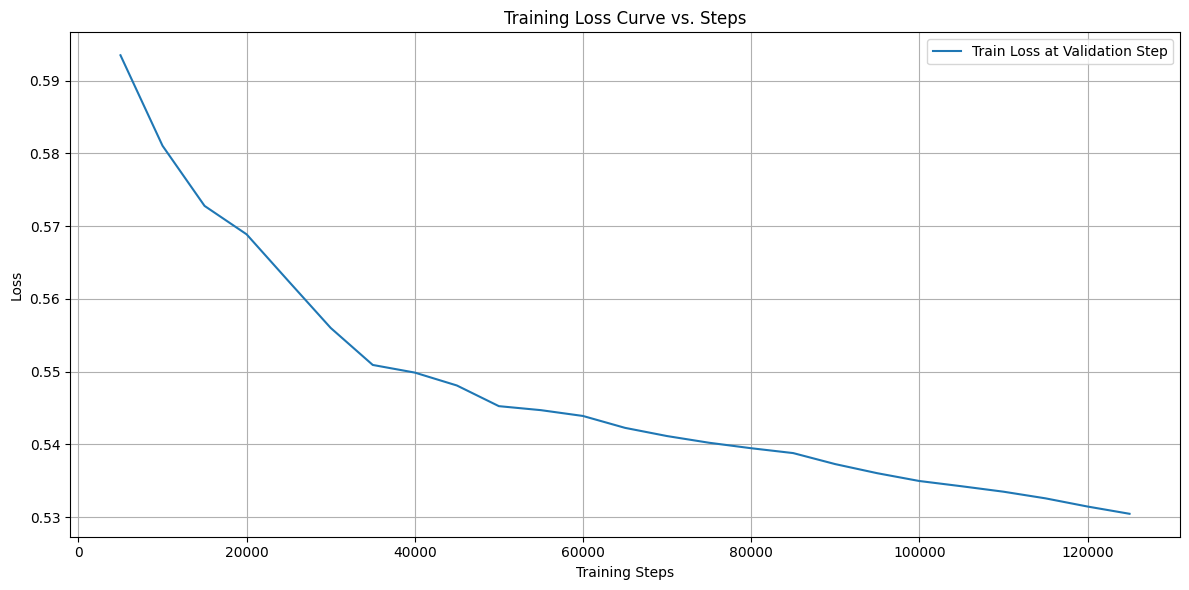

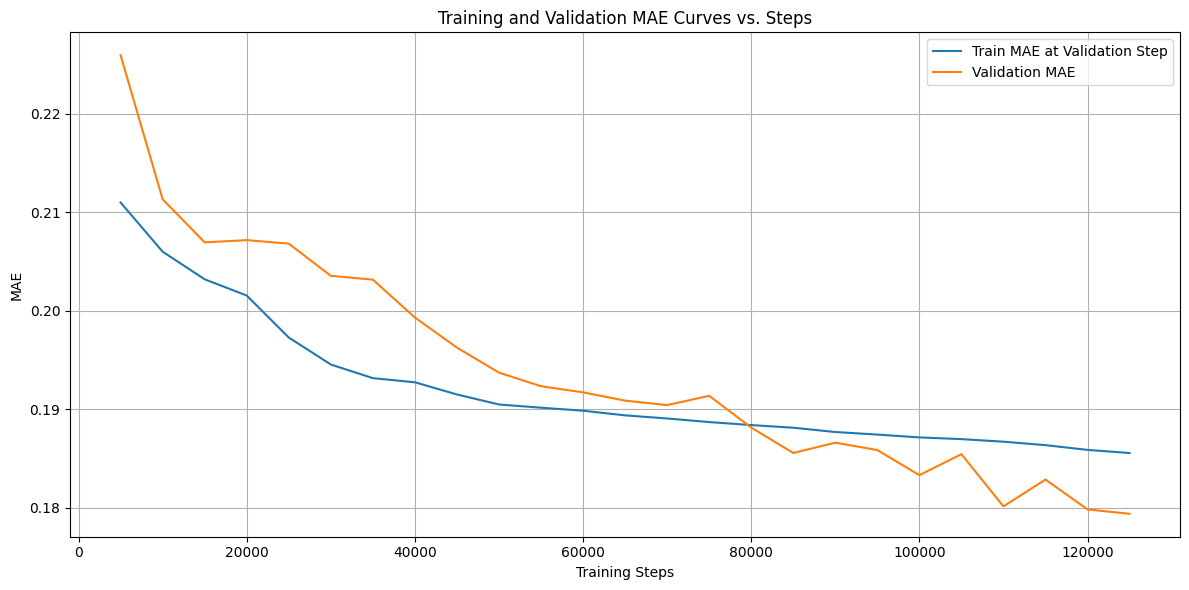

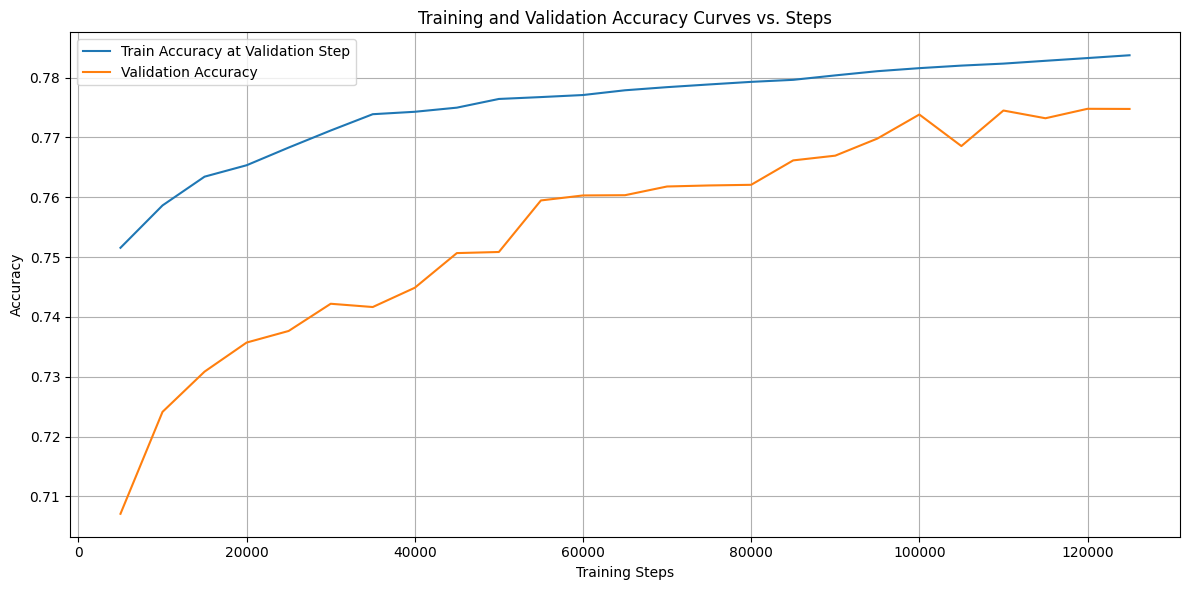

In [2]:
import matplotlib.pyplot as plt
import pickle

with open('training_metrics.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Accessing individual arrays
steps = loaded_data['steps']
train_losses = loaded_data['train_losses']
train_maes = loaded_data['train_maes']
val_maes = loaded_data['val_maes']
train_win_accs = loaded_data['train_win_accs']
val_win_accs = loaded_data['val_win_accs']

# --- Plotting Loss Curves ---
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(steps, train_losses, label='Train Loss at Validation Step')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve vs. Steps')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout

# --- Plotting MAE Curves ---
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(steps, train_maes, label='Train MAE at Validation Step')
plt.plot(steps, val_maes, label='Validation MAE')
plt.xlabel('Training Steps')
plt.ylabel('MAE')
plt.title('Training and Validation MAE Curves vs. Steps')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout

# --- Plotting Accuracy Curves ---
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(steps, train_win_accs, label='Train Accuracy at Validation Step')
plt.plot(steps, val_win_accs, label='Validation Accuracy')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves vs. Steps')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout

# Show all the plots
plt.show()